In [86]:
import os
import sys
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from functools import partial
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
print(f"base_path: {base_path}")
sys.path.append(base_path)

base_path: /home/uoscisai/Experiments/Football/sr-press


In [87]:
from express.databases import SQLiteDatabase
from express.datasets import PressingDataset
from express.components import press
from express.visualization import plot_action
from express.utils import add_names
import express.config as config

In [88]:
model = "xgboost" #"xgboost"
trial = 0

save_path = os.path.join(base_path, "stores", "model", model, f"{trial:03d}", "component.pkl")
path = Path(save_path)
component = pickle.load(path.open(mode="rb"))
component

In [89]:
TEST_DB_PATH = os.path.join(base_path, "stores/test_database.sqlite")
test_db = SQLiteDatabase(TEST_DB_PATH)
dataset_test = partial(PressingDataset, path=os.path.join(base_path, "stores", "datasets", "test"))

if model == "xgboost":
    xfns = ["startlocation", "closest_11_players", 'actiontype']
    nb_prev_actions = 3
elif model == "soccermap":
    xfns = ["startlocation", "freeze_frame_360"]
    nb_prev_actions = 1

test_dataset = PressingDataset(
    path= os.path.join(base_path, "stores", "datasets", "test"),
    xfns=xfns,
    yfns=["counterpress"],
    load_cached=True,
    nb_prev_actions=nb_prev_actions
)

print(f"Test DataSet: {test_dataset.features.shape}")
print(f"Test Dataset: {test_dataset.labels.value_counts().to_dict()}")

Test DataSet: (12406, 198)
Test Dataset: {(False,): 9954, (True,): 2452}


In [148]:
test_dataset.labels[test_dataset.labels.counterpress == False][:20]

counterpress
game_id action_id              
3857255 6                 False
        17                False
        22                False
        25                False
        40                False
        56                False
        74                False
        77                False
        82                False
        86                False
        93                False
        126               False
        134               False
        143               False
        149               False
        159               False
        166               False
        174               False
        187               False
        196               False

In [130]:
component.test(dataset_test)

{'precision': 0.7415496619864794,
 'recall': 0.5815660685154975,
 'f1': 0.6518857142857143,
 'log_loss': 0.3072738098017734,
 'brier': 0.08981742816209641,
 'roc_auc': 0.900333663727535}

<Axes: title={'center': 'pressing & fail: 0.03184'}>

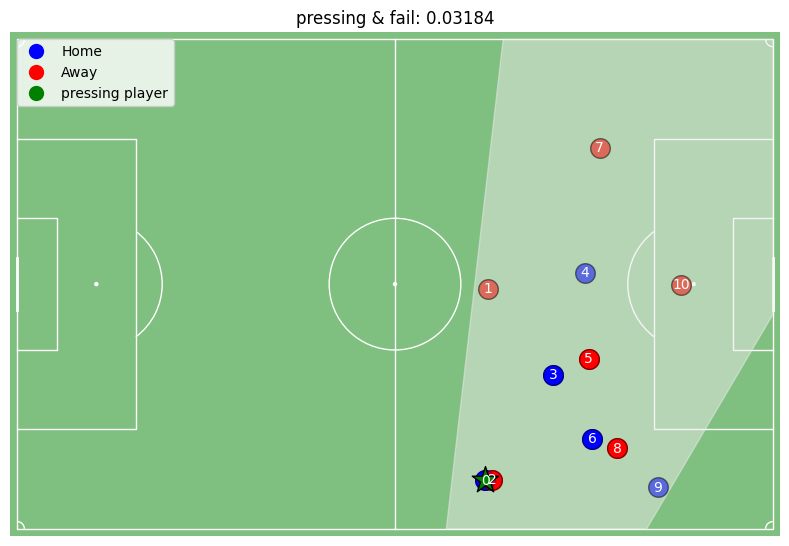

In [158]:
game_id = 3857255
action_id = 86
actions = add_names(test_db.actions(game_id))
home_team_id, away_team_id = test_db.get_home_away_team_id(game_id = game_id)

prob = component.predict(dataset_test).loc[(game_id, action_id)]
plot_action(actions.loc[(game_id, action_id)], home_team_id=home_team_id, prob=prob)

In [159]:
freeze_frame_360

,teammate,actor,keeper,x,y
0,False,False,False,51.645559,27.917595
1,True,False,False,47.593587,17.375841
2,False,False,False,45.844519,17.802686
3,True,False,False,44.505962,31.248736
4,True,True,False,44.100001,20.485000
5,False,False,False,43.758137,22.549604
6,True,False,False,37.487958,26.201432
7,False,False,False,35.706193,27.759630
8,False,False,False,35.638550,24.514533
9,True,False,False,35.236136,39.034777


In [164]:
from express.simulates import expressXGBoostComponent

simulate = expressXGBoostComponent(component, 
                                   db= test_db,
                                   xfns= test_dataset.xfns.keys(),
                                   nb_prev_actions=nb_prev_actions)


freeze_frame_idx = 3
freeze_frame_360 = pd.DataFrame(actions.loc[(game_id, action_id)]["freeze_frame_360"])
x, y = freeze_frame_360.loc[freeze_frame_idx, ["x", "y"]]
dx_range = range(-5, 5)  
dy_range = range(-5, 5)
xy = [(x + dx, y + dy) for dx in dx_range for dy in dy_range]

simulated_instances = simulate.simulate(game_id= game_id, action_id= action_id, 
                                     freeze_frame_idx= freeze_frame_idx, xy= xy)
simulated_instances

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.40it/s]


In [165]:
raw_instance = next((instance for instance in simulated_instances if instance.raw), None)
if not raw_instance:
    raise ValueError("raw가 True인 인스턴스가 없습니다.")

k = 8
sorted_instances = sorted(
    [instance for instance in simulated_instances if not instance.raw],
    key=lambda x: x.prob,
    reverse=True
)

instances = [raw_instance] + sorted_instances[:k]
instances

In [166]:
def _fix_direction_of_play(actions: pd.DataFrame, home_team_id: int) -> pd.DataFrame:
    away_idx = (actions.team_id != home_team_id).values
    for col in ["start_x", "end_x"]:
        actions.loc[away_idx, col] = config.field_length - actions[away_idx][col].values
    for col in ["start_y", "end_y"]:
        actions.loc[away_idx, col] = config.field_width - actions[away_idx][col].values

    return actions

def _sb_freeze_frame_to_spadl(freeze_frame,invert: bool = False):
    if not isinstance(freeze_frame, list):
        return None
    freezedf = pd.DataFrame(
        {
            "teammate": e["teammate"],
            "actor": e["actor"],
            "keeper": e["keeper"],
            "x": e["x"],
            "y": e["y"],
        }
        for e in freeze_frame
    )

    if invert:
        freezedf["x"] = config.field_length - freezedf["x"].values
        freezedf["y"] = config.field_width - freezedf["y"].values
    return list(freezedf.to_dict("records"))

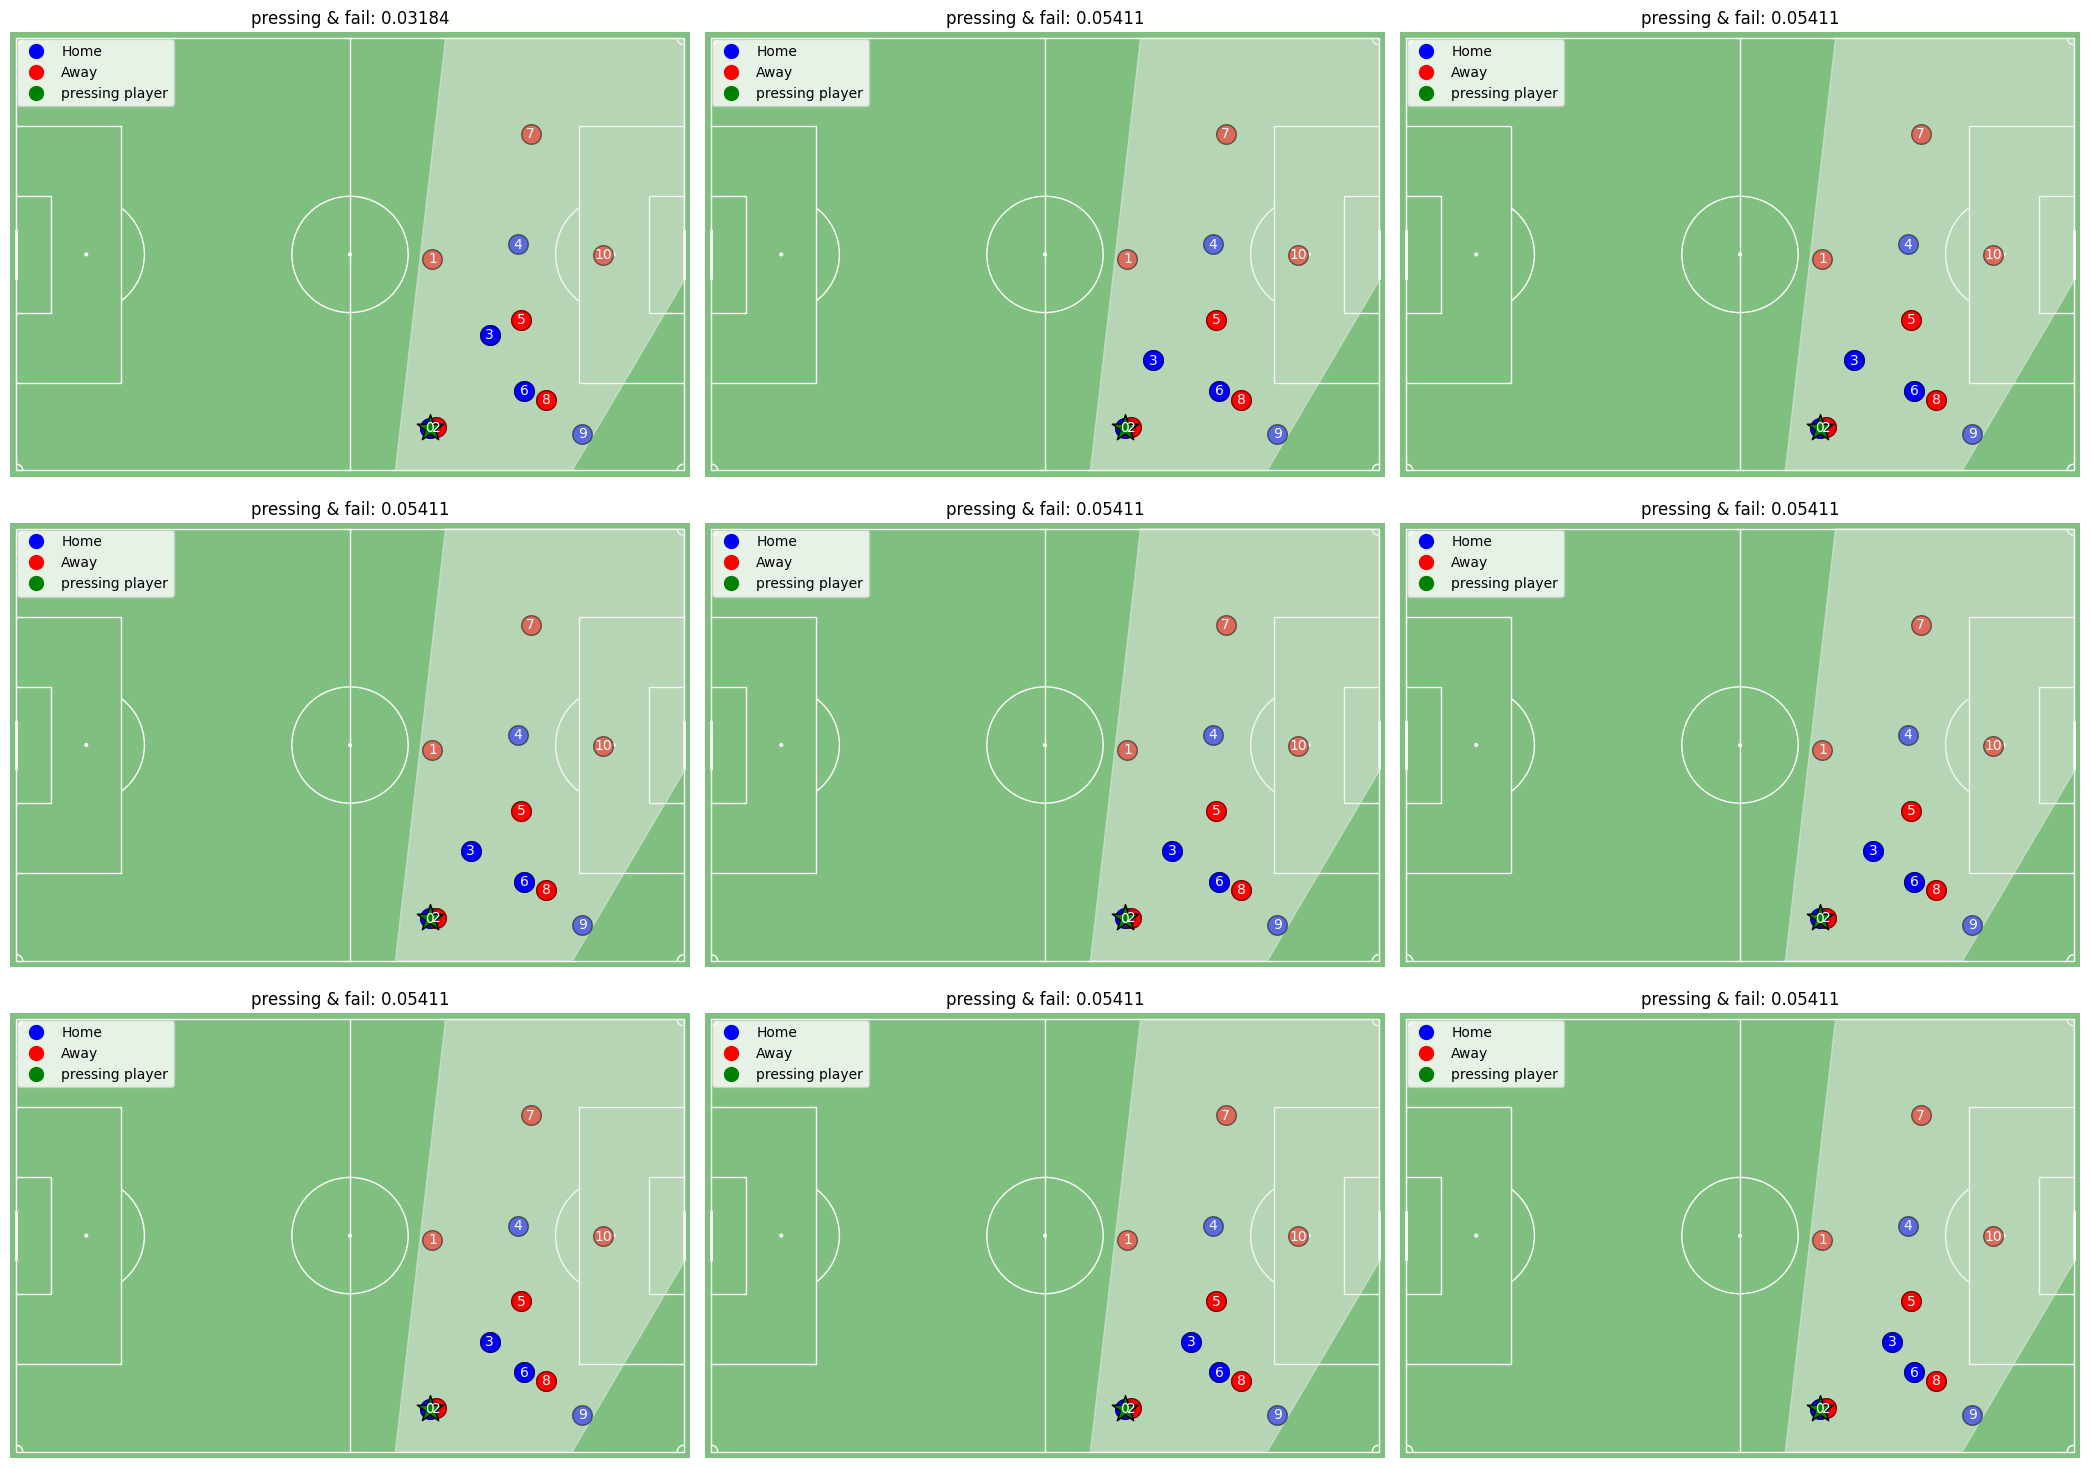

In [167]:
cols = int(k ** 0.5) + 1  # 가로
rows = (k + cols - 1) // cols  # 세로

fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 5 * rows))
axes = axes.flatten()

for i, instance in enumerate(instances):
    print(instance)
    action = instance.data # 모든 플레이가 왼쪽에서 오른쪽으로 플레이되므로..다시 원정은 오른쪽으로 변환
    # action = _fix_direction_of_play(action, home_team_id)
    # action["freeze_frame_360"] = action.assign(away_idx=(action.team_id != home_team_id)).apply(
    #     lambda x: _sb_freeze_frame_to_spadl(x.freeze_frame_360, x.away_idx), axis=1
    # )
    prob = instance.prob

    plot_action(
        action= action.squeeze(),
        home_team_id=home_team_id,
        prob=prob,
        ax=axes[i]
    )
    

    # title_prefix = "Raw Data" if (row["dx"] == 0 and row["dy"] == 0) else f"Top {i}"
    # axes[i].set_title(f"{title_prefix} (prob: {row['probability']:.2f})")

# 레이아웃 조정
plt.tight_layout()
plt.show()


### Application

In [79]:
idx = (3857255, 6)

sample_features = {}
sample_target = {}
sample_features = test_dataset.features.loc[idx].to_dict()
game_id, action_id = test_dataset.features.loc[idx].name

sample_target = test_dataset.labels.loc[idx].to_dict()
game_id, action_id = test_dataset.labels.loc[idx].name

sample = {
    "game_id": game_id,
    "action_id": action_id,
    **sample_features,
    **sample_target,
}
sample

{'game_id': 3857255,
 'action_id': 6,
 'start_x_a0': 85.66250000000001,
 'start_y_a0': 55.76,
 'start_x_a1': 76.475,
 'start_y_a1': 59.075,
 'start_x_a2': 62.0375,
 'start_y_a2': 67.575,
 'teammate_1_x_a0': nan,
 'teammate_1_y_a0': nan,
 'teammate_1_distance_a0': nan,
 'teammate_2_x_a0': nan,
 'teammate_2_y_a0': nan,
 'teammate_2_distance_a0': nan,
 'teammate_3_x_a0': nan,
 'teammate_3_y_a0': nan,
 'teammate_3_distance_a0': nan,
 'teammate_4_x_a0': nan,
 'teammate_4_y_a0': nan,
 'teammate_4_distance_a0': nan,
 'teammate_5_x_a0': nan,
 'teammate_5_y_a0': nan,
 'teammate_5_distance_a0': nan,
 'teammate_6_x_a0': nan,
 'teammate_6_y_a0': nan,
 'teammate_6_distance_a0': nan,
 'teammate_7_x_a0': nan,
 'teammate_7_y_a0': nan,
 'teammate_7_distance_a0': nan,
 'teammate_8_x_a0': nan,
 'teammate_8_y_a0': nan,
 'teammate_8_distance_a0': nan,
 'teammate_9_x_a0': nan,
 'teammate_9_y_a0': nan,
 'teammate_9_distance_a0': nan,
 'teammate_10_x_a0': nan,
 'teammate_10_y_a0': nan,
 'teammate_10_distance_

In [80]:
from express.components.soccermap import ToSoccerMapTensor
transform = ToSoccerMapTensor(dim=(68, 104))

tensor_data = transform(sample)[0][7]

print(tensor_data.shape)
tensor_data

KeyError: 'freeze_frame_360_a0'

In [ ]:
component.model(transform(sample)[0])

In [49]:
df_pred = pd.DataFrame(y_pred, index=test_dataset.features.index, columns=test_dataset.labels.columns)
df_pred

NameError: name 'y_pred' is not defined

In [50]:
game_ids = list(df_pred.index.get_level_values('game_id').unique())
game_id = 3857255#game_ids[0]

print(game_id)
df_actions = add_names(test_db.actions(game_id)).reset_index()
df_actions.head()

NameError: name 'df_pred' is not defined

In [51]:
pd.DataFrame(df_actions.loc[pressure_idx]["freeze_frame_360"])

NameError: name 'df_actions' is not defined

In [52]:
condition = (df_actions["type_name"] == "pressing")
# condition = (df_actions["type_name"] == "pressing") & (df_actions["result_name"] == "success")
# condition = (df_actions["action_id"] == 1609)
pressure_idx = df_actions[condition].index[0]

home_team_id, away_team_id = test_db.get_home_away_team_id(game_id = game_id)

for idx in range(pressure_idx-1, pressure_idx+1):
    in_visible_area_360 = df_actions.loc[idx]["in_visible_area_360"]
    actiontype_id = df_actions.at[idx, "type_id"]
    index = tuple(df_actions.loc[idx, ["game_id", "action_id"]].values)
    prob = df_pred.loc[index, "counterpress"] if actiontype_id == config.actiontypes.index("pressing") else None

    plot_action(df_actions.loc[idx], show_visible_area=in_visible_area_360, home_team_id=home_team_id, prob=prob)

NameError: name 'df_actions' is not defined